# Read

The data of the selected pairs to trade.

In [1]:
import models
import numpy as np
import pandas as pd

from data import *

In [2]:
filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)
display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,AMZN,BNBUSDT,0.877059,-3.631203,0.005192,True,-3.545100,0.028601,True
3,AMZN,TRXUSDT,0.814577,-3.869803,0.002269,True,-3.387413,0.043768,True
4,SPY_ETF,AVAXUSDT,0.847292,-3.309927,0.014441,True,-3.698512,0.018406,True
5,SPY_ETF,ETHUSDT,0.862483,-3.428205,0.010034,True,-3.737367,0.016394,True
6,EQQQ_ETF,BNBUSDT,0.886060,-3.816404,0.002744,True,-3.670509,0.019987,True
7,BNBUSDT,ADAUSDT,0.901459,-3.279504,0.015820,True,-3.775562,0.014607,True
8,BNBUSDT,BTCUSDT,0.884604,-2.909961,0.044202,True,-3.393160,0.043116,True
9,BNBUSDT,XRPUSDT,0.919004,-3.380878,0.011628,True,-4.054516,0.005995,True


We have the following pairs to trade:
- GOOG and GOOGL: Google Series A and Google Series C - since both securities depict the performance of the same company, we do not want to consider this pair in our portfolio
- META and DAX ETF
- AMZN and BNBUSDT: Amazon and Binance Coin
- AMZN and TRXUSDT: Amazon and TRON cryptocurrency
- S&P 500 ETF and AVAXUDST: S&P 500 ETF and Avalanche cryptocurrency
- S&P 500 ETF and ETHUDST: S&P 500 ETF and Ethereum cryptocurrency
- EQQQ ETF and BNBUSDT: Nasdaq 100 ETF and Binance coin cryptocurrency
- BNBUSDT and ADAUSDT: Binance Coin and Cardano cryptocurrency
- BNBUSDT and BTCUDST: Binance Coin and Bitcoin
- BNBUSDT and TRXUDST: Binance Coin and TRON cryptocurrency
- BNBUSDT and XRPUDST: Binance Coin and XRP (Ripple) cryptocurrency.

As we can see, the portfolio is composed mostly of cryptocurrencies, but there is also an equity pair (Meta/DAX ETF) as well as equity-cryptocurrency pairs: S&P 500 ETF/Avalanche and S&P 500 ETF/Ethereum. Such a composition, in hindsight, should not come as a surprise because:
- **Cryptocurrency pairs** are driven by similar factors and in this market events on all tradeable coins are still mostly driven by Bitcoin, hence high correlations and time-invariant spreads are fairly expected
- **Equity-cryptocurrency pairs**: S&P 500 ETF against Avalanche and Ethereum reflect the increasing interest in and integration of the traditional financial markets and digital assets, while Amazon against Binance coin and TRON may capture the relationship between large-cap technology firms and the broader crypto ecosystem - AWS is widely used in the blockchain infrastructure and Binance Coin is tied to one of the largest cryptocurrency exchanges
- The **equity-equity pair** Meta/DAX ETF suggests a potential macroeconomic link: Meta is a global tech giant while DAX represents the broader European market; hence these two correlating may be drien by similar trends and/or risk sentiments.

In [3]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
df_full = pd.read_csv('df_full.csv').drop(['Unnamed: 0'], axis=1)
df_full = df_full[df_full['Symbol'].isin(unique_tickers)].copy().reset_index(drop=True)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
AMZN BNBUSDT
AMZN TRXUSDT
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT BTCUSDT
BNBUSDT XRPUSDT
BNBUSDT TRXUSDT
********************
Unique tickers:
META
AMZN
SPY_ETF
EQQQ_ETF
BNBUSDT
DAXEX_ETF
TRXUSDT
AVAXUSDT
ETHUSDT
ADAUSDT
BTCUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
128606,2024-11-26 00:35:00,92400.08,92627.35,92326.31,92435.22,BTCUSDT
110218,2024-11-16 21:40:00,3096.16,3099.88,3093.76,3094.00,ETHUSDT
24213,2024-10-05 05:50:00,25.67,25.69,25.63,25.65,AVAXUSDT
80213,2024-11-02 00:30:00,24.76,24.79,24.74,24.79,AVAXUSDT
39215,2024-10-12 16:25:00,577.60,577.80,577.50,577.60,BNBUSDT


## Prepare Spreads of the Final Pairs

Once we have the pairs series prepared and aligned in time, we can proceed with spread calculation. Spread between two assets at time $t$ is given directly as the difference between two asset prices, i.e., $$\text{Spread}_{AB, t} = p_{A,t} - p_{B, t}$$ where $p_A$ - price of asset A and $p_B$ - price of asset B.

The next step is to normalize the spread by subtracting the mean and dividing by standard deviation, given as $$\text{Normalized Spread}_t = \frac{\text{Spread}_{AB, t} - \mu_{\text{Spread}_{AB}}}{\sigma_{\text{Spread}_{AB}}}$$

In the base case scenario, a **trading signal** is identified when spread is below -2 or above 2 with the following interpretation:
- $\text{Spread}_{AB, t} < -2$: buy A, sell B
- $\text{Spread}_{AB, t} > 2$: buy B, sell A.

## Additional Considerations

Our trading strategy will work flawlessly if there is always a sequence of events:
1. *Signal* Buy 1 unit of asset A, sell 1 unit of asset B.
2. No action for $n$ periods.
3. *Signal* Sell 1 unit of asset A, buy 1 unit of asset B.

However, in reality, we cannot assume that such a scenario will always occur. Below we have listed some exceptions and how we have handled them:
- A sequence of consecutive trading signals in the next $k$ forecasts: due to the assumption of next-period-opening-price execution (we are unable to open a position at the same tick that feeds the forecast), we must consider the scenario in which we receive more than one trading signal in a row and how we manage the positions. The possibilities are as follows:
    - *First signal entry*: immediate reaction resulting in increasing our exposure on assets A and B until the exposure limit has been reached, which we discuss in the next point; ensures timely reaction to the forecast, but may lead to unnecessarily frequent trades and transaction costs;
    - *Last signal entry*: waiting until the sequence of trading signals is interrupted by a 'No action' forecast; reduces information noise but may execute trades at less favorable prices;
    - *Threshold-based confirmation*: entering a trade only after receiving $m$ trading subsequent signals, e.g., $m=3$; similarly to last signal entry, it helps avoid information noise, but may lead to less favorable execution; this approach 
- Risk management with respect to portfolio asset allocation: having up to 10 unique assets (assuming all trading pairs have generated signals within the same time frame), we must take certain measures to ensure diversification and avoid overexposure to a single asset by assuming that we limit the exposure to any single asset to **25%** of the total portfolio value.
- Trending spread instead of mean reversion: we can forcefully close the position if the spread does not generate an opposite trading signal within $X$ periods
- Conflicting trading signals: it is possible that while on the pair A-B there is a long/short signal, on the pair A-C there is a short/long signal and the position on A would net to 0. Such a situation can be observed in the Forex market and we are allowing it in this project.

# Model Training

Each pair has its own model trained. 

<u>**NOTE**</u> Currently the models add 5 lags of normalized spread to have some features for modeling.

,META,DAXEX_ETF,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-28 12:30:00,580.450,162.10,418.350,-0.524746,No action
2024-10-28 12:35:00,577.670,162.10,415.570,-0.671628,No action
2024-10-28 13:00:00,577.755,162.04,415.715,-0.663967,No action
2024-10-28 13:10:00,577.320,162.08,415.240,-0.689064,No action
2024-10-28 13:20:00,576.615,162.12,414.495,-0.728426,No action


Ridge Regression MSE: 0.01782673148316411
XGBoost MSE: 0.019349448864296057
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM MSE: 0.04392979834305528
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RNN MSE: 0.03582197445281891
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Transformer MSE: 0.058169895818903965


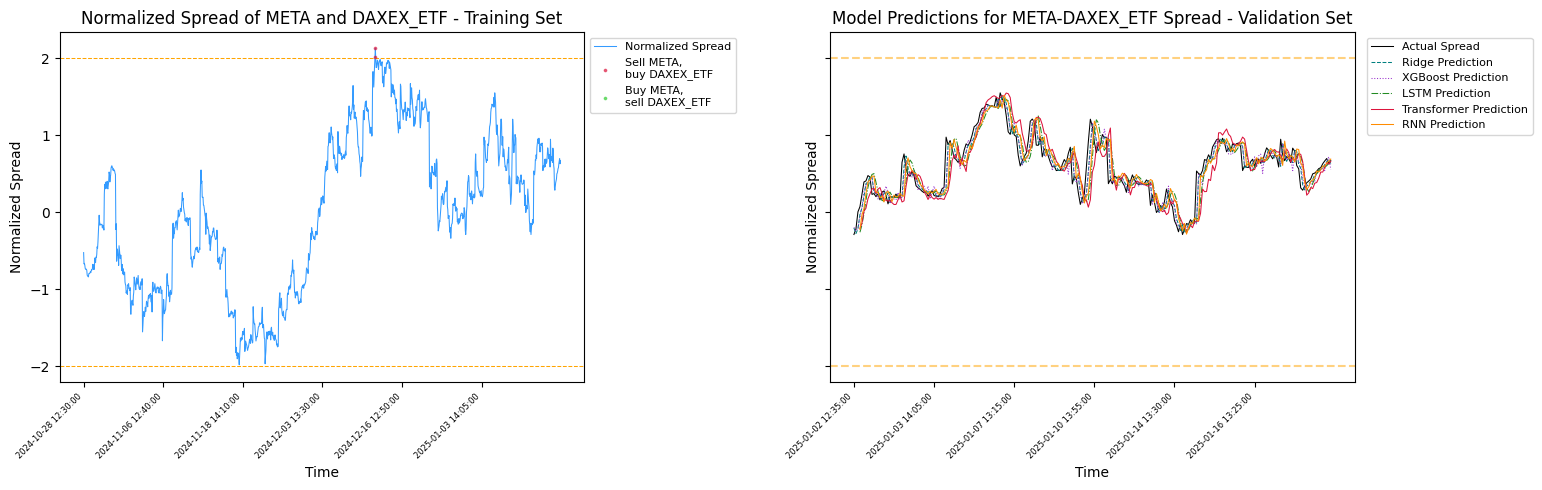

,AMZN,BNBUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-14 12:30:00,189.0517,588.6,-399.5483,1.021407,No action
2024-10-14 12:35:00,188.8700,588.7,-399.8300,1.014604,No action
2024-10-14 12:40:00,189.2599,589.0,-399.7401,1.016775,No action
2024-10-14 12:45:00,189.3700,588.1,-398.7300,1.041169,No action
2024-10-14 12:50:00,189.0700,588.0,-398.9300,1.036339,No action


Ridge Regression MSE: 0.0019103202978580699
XGBoost MSE: 0.0021430430174144556
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM MSE: 0.003916847707999986
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RNN MSE: 0.0037966990962830377
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Transformer MSE: 0.006220565757362072


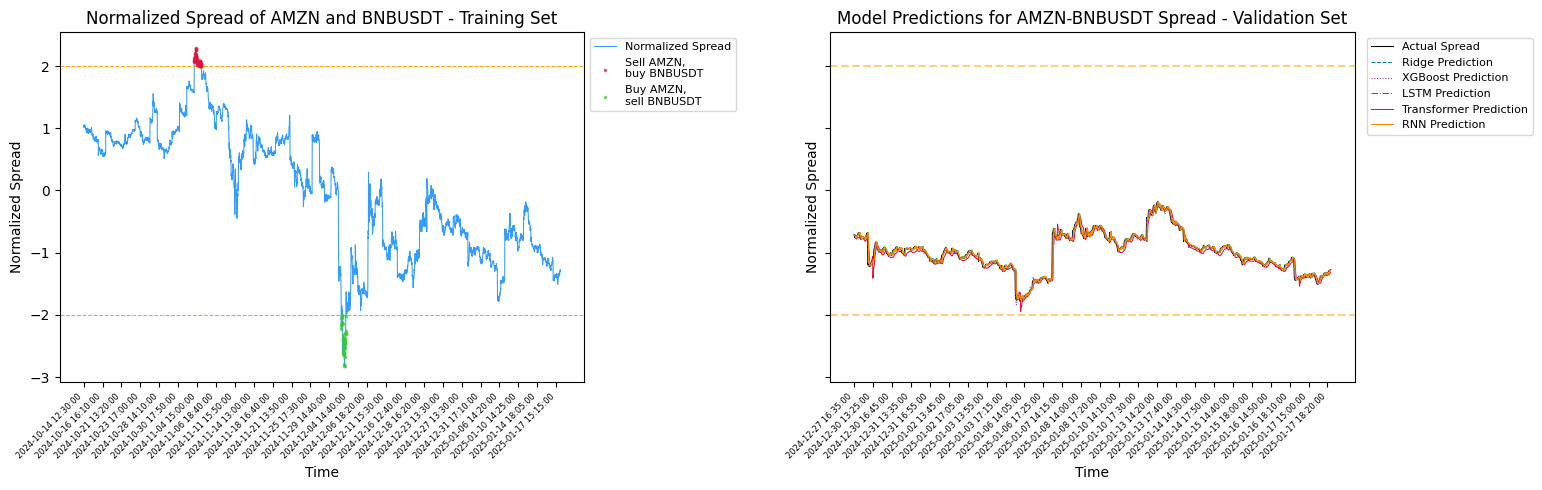

,AMZN,TRXUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-14 12:30:00,189.0517,0.1607,188.8910,-1.412753,No action
2024-10-14 12:35:00,188.8700,0.1606,188.7094,-1.424992,No action
2024-10-14 12:40:00,189.2599,0.1606,189.0993,-1.398714,No action
2024-10-14 12:45:00,189.3700,0.1605,189.2095,-1.391287,No action
2024-10-14 12:50:00,189.0700,0.1606,188.9094,-1.411513,No action


Ridge Regression MSE: 0.0010060301065175894
XGBoost MSE: 0.0017404794237834962
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM MSE: 0.0023913028286674395
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RNN MSE: 0.0021727725474830245
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Transformer MSE: 0.0049887529697722815


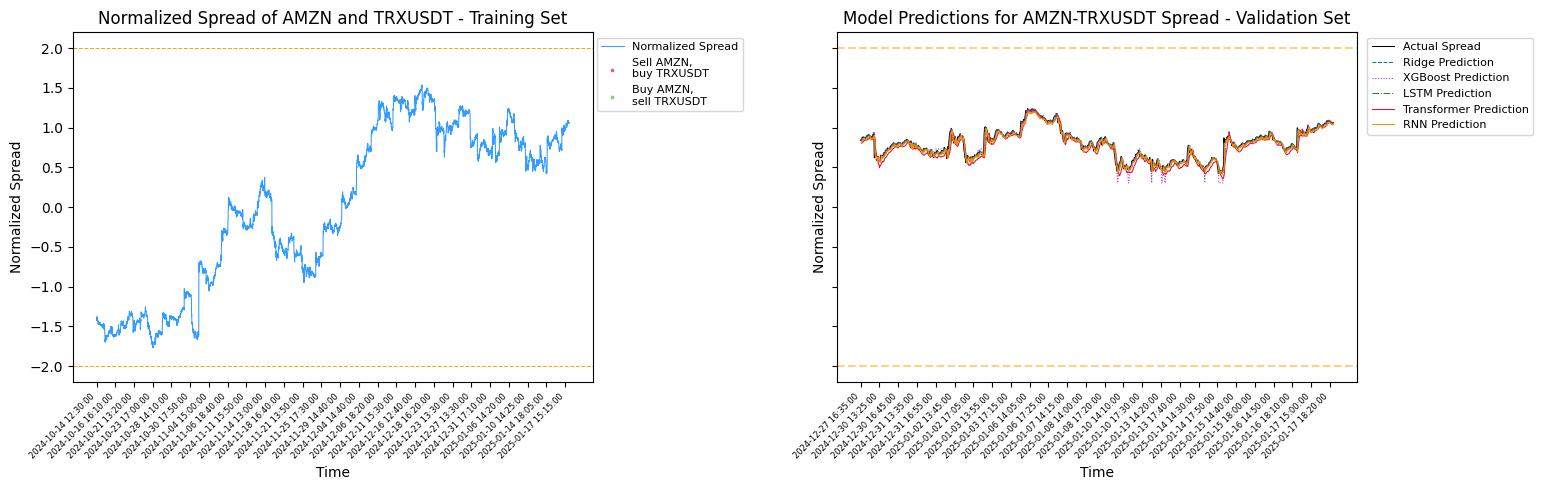

,SPY_ETF,AVAXUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-14 12:30:00,581.80,29.17,552.63,-0.410641,No action
2024-10-14 12:35:00,581.86,29.17,552.69,-0.399412,No action
2024-10-14 12:40:00,582.14,29.20,552.94,-0.352623,No action
2024-10-14 12:45:00,583.03,29.15,553.88,-0.176699,No action
2024-10-14 12:50:00,582.76,29.17,553.59,-0.230973,No action


Ridge Regression MSE: 0.016387014719814547
XGBoost MSE: 0.03277059525936617
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM MSE: 0.03577176236727802
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RNN MSE: 0.03467723907585218
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Transformer MSE: 0.04649499867418451


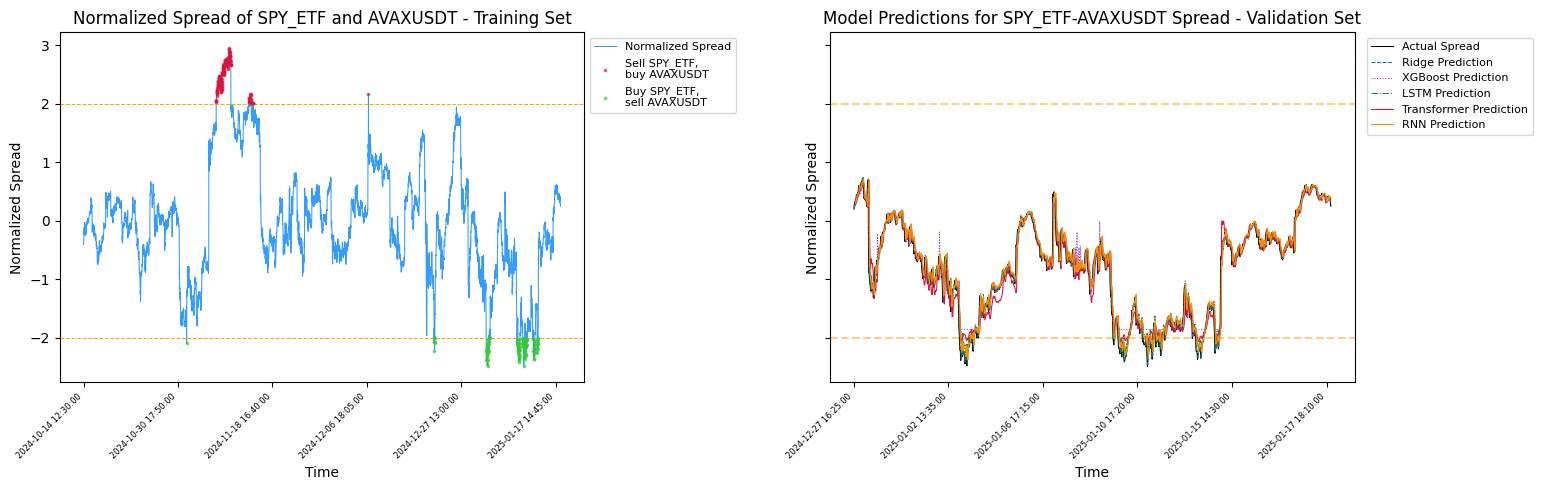

,SPY_ETF,ETHUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-14 12:30:00,581.80,2627.09,-2045.29,1.262438,No action
2024-10-14 12:35:00,581.86,2625.69,-2043.83,1.265674,No action
2024-10-14 12:40:00,582.14,2626.97,-2044.83,1.263457,No action
2024-10-14 12:45:00,583.03,2625.72,-2042.69,1.268201,No action
2024-10-14 12:50:00,582.76,2623.80,-2041.04,1.271858,No action


Ridge Regression MSE: 0.0014018351952485618
XGBoost MSE: 0.0017076924503724251
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM MSE: 0.0032383074160318337
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RNN MSE: 0.0027703273897298477
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Transformer MSE: 0.010328318003666116


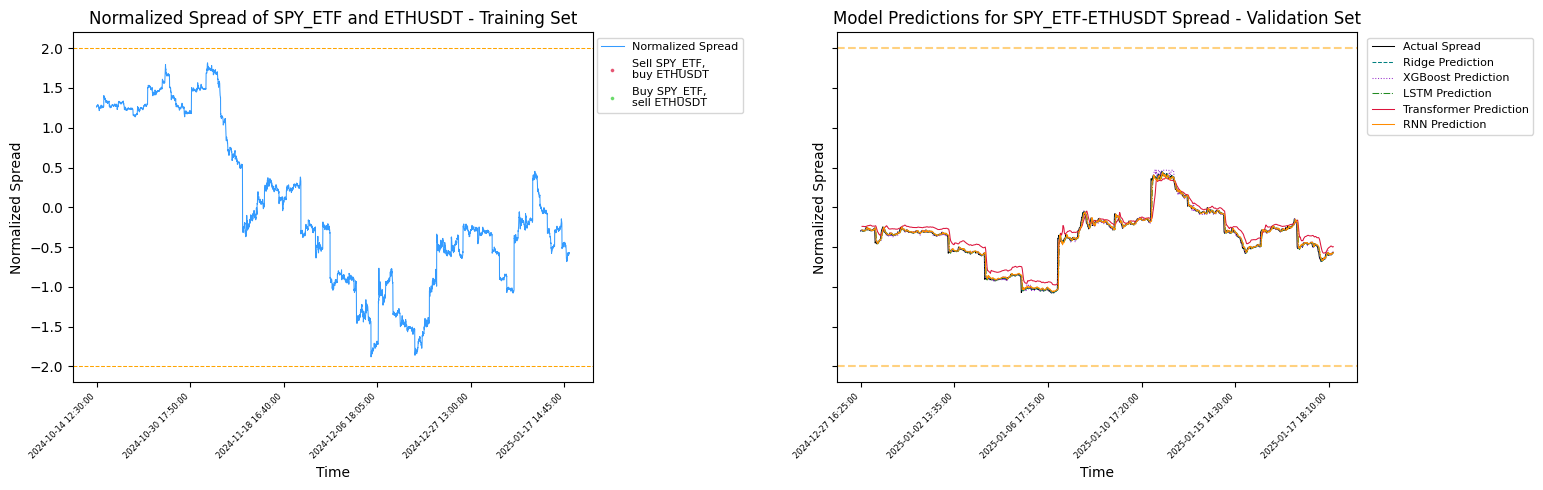

,EQQQ_ETF,BNBUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-31 07:00:00,37990.0,578.2,37411.8,-2.371734,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:05:00,38001.0,580.1,37420.9,-2.364239,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:10:00,37986.0,579.0,37407.0,-2.375687,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:25:00,38011.0,579.6,37431.4,-2.355591,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:35:00,37978.0,577.9,37400.1,-2.381370,"Buy EQQQ_ETF, sell BNBUSDT"


Ridge Regression MSE: 0.0022939796313981306
XGBoost MSE: 0.0269699852956496
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM MSE: 0.005138287018568158
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RNN MSE: 0.00469537160012603
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Transformer MSE: 0.02555582474692004


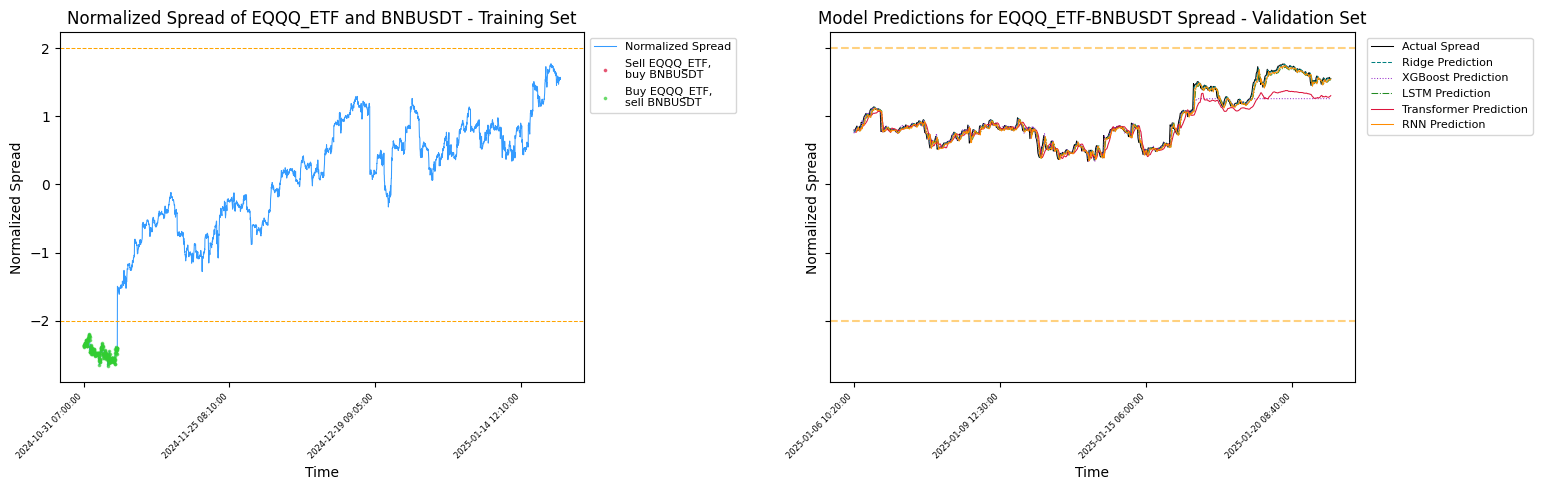

,BNBUSDT,ADAUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,0.3521,555.9479,-1.650770,No action
2024-10-04 16:05:00,556.5,0.3523,556.1477,-1.647201,No action
2024-10-04 16:10:00,556.0,0.3523,555.6477,-1.656132,No action
2024-10-04 16:15:00,555.9,0.3523,555.5477,-1.657918,No action
2024-10-04 16:20:00,555.5,0.3515,555.1485,-1.665049,No action


Ridge Regression MSE: 0.000309015035781539
XGBoost MSE: 0.00040150089336995717
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
LSTM MSE: 0.001404536706340144
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
RNN MSE: 0.0006688154043757637
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
Transformer MSE: 0.0019221012348676816


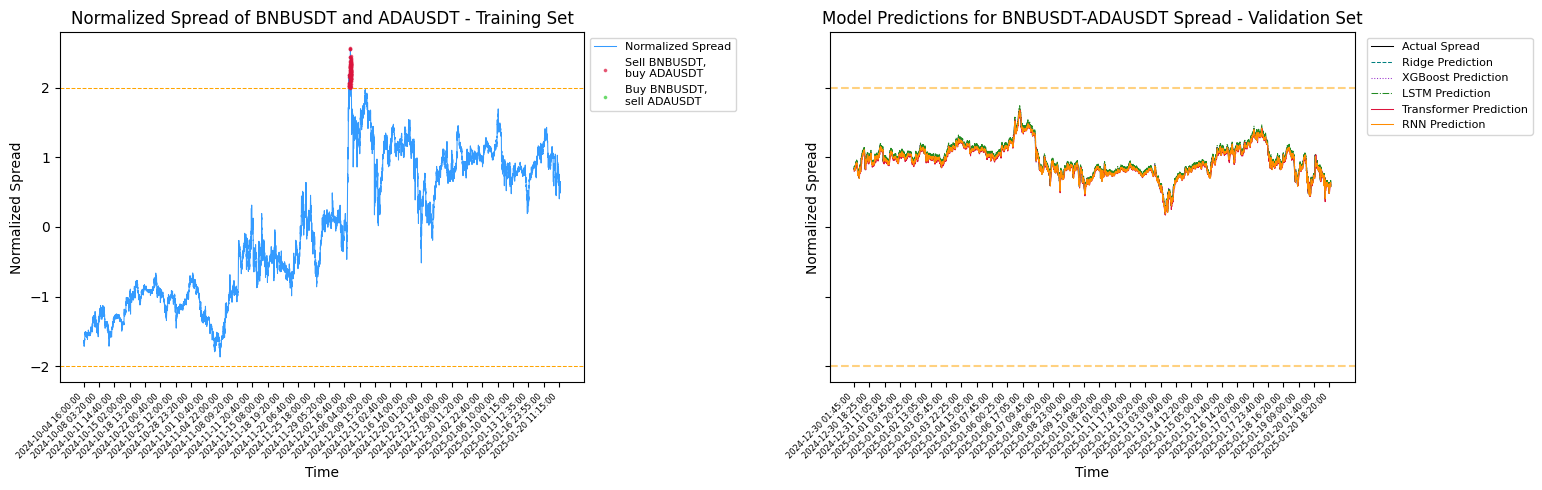

,BNBUSDT,BTCUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,62198.02,-61641.72,1.713864,No action
2024-10-04 16:05:00,556.5,62165.99,-61609.49,1.716112,No action
2024-10-04 16:10:00,556.0,62079.60,-61523.60,1.722103,No action
2024-10-04 16:15:00,555.9,62100.00,-61544.10,1.720673,No action
2024-10-04 16:20:00,555.5,62045.98,-61490.48,1.724414,No action


Ridge Regression MSE: 0.00015764781973183923
XGBoost MSE: 0.00023501624341341277
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
LSTM MSE: 0.00034531187051248697
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
RNN MSE: 0.0003066732051785876
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Transformer MSE: 0.0017646733559847766


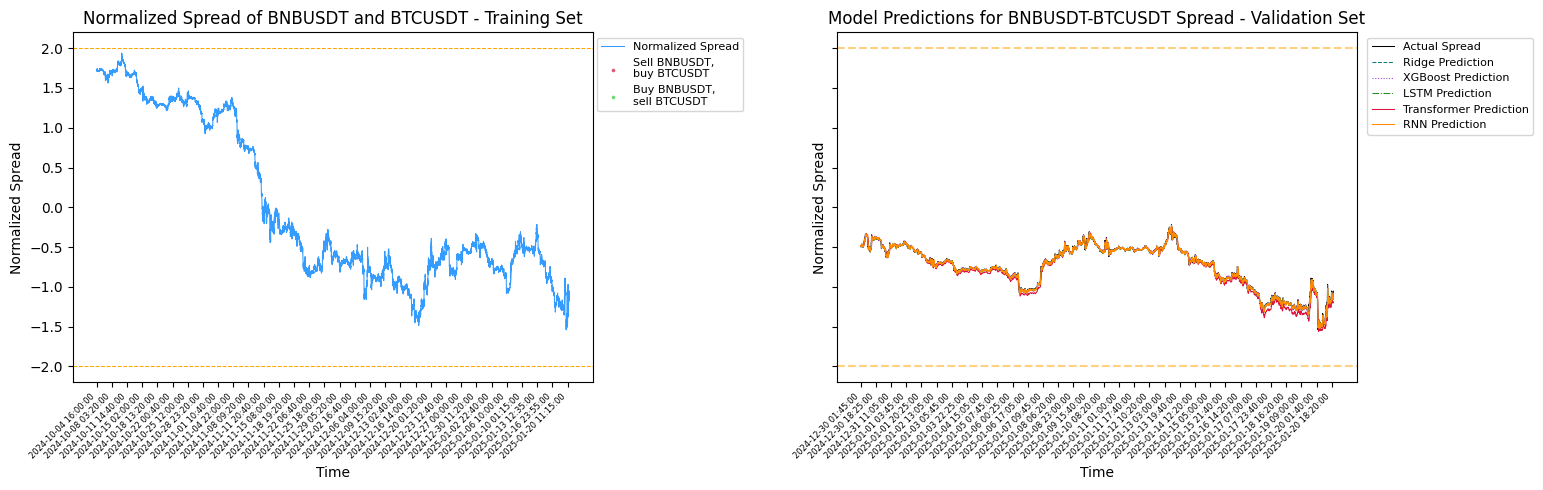

,BNBUSDT,XRPUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,0.5334,555.7666,-1.655934,No action
2024-10-04 16:05:00,556.5,0.5339,555.9661,-1.652335,No action
2024-10-04 16:10:00,556.0,0.5335,555.4665,-1.661347,No action
2024-10-04 16:15:00,555.9,0.5325,555.3675,-1.663133,No action
2024-10-04 16:20:00,555.5,0.5317,554.9683,-1.670334,No action


Ridge Regression MSE: 0.00031298741302476974
XGBoost MSE: 0.0004038365387565238
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
LSTM MSE: 0.0006326271929453941
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
RNN MSE: 0.0006138594644945946
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
Transformer MSE: 0.003466701013958038


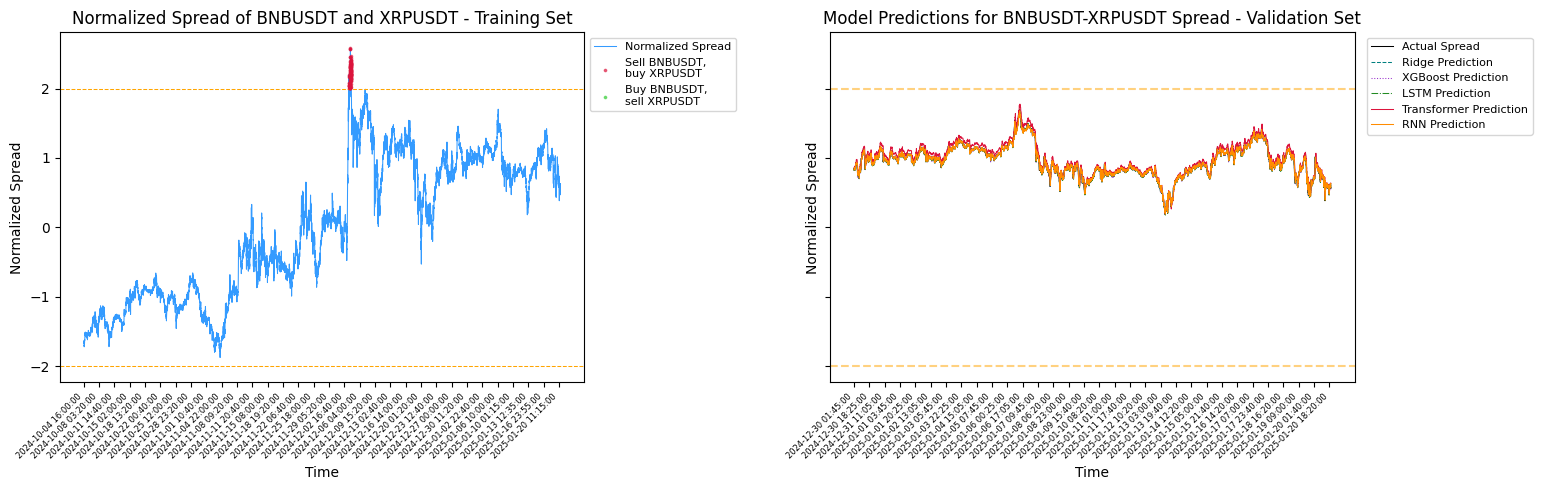

,BNBUSDT,TRXUSDT,Spread,NormalizedSpread,TradingSignal
OpenTime,,,,,
2024-10-04 16:00:00,556.3,0.1566,556.1434,-1.649992,No action
2024-10-04 16:05:00,556.5,0.1566,556.3434,-1.646435,No action
2024-10-04 16:10:00,556.0,0.1566,555.8434,-1.655328,No action
2024-10-04 16:15:00,555.9,0.1564,555.7436,-1.657103,No action
2024-10-04 16:20:00,555.5,0.1564,555.3436,-1.664218,No action


Ridge Regression MSE: 0.00030782706034597235
XGBoost MSE: 0.00040781890591594236
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
LSTM MSE: 0.0007243086730959862
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
RNN MSE: 0.0007745675752209354
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
Transformer MSE: 0.0015998822125788059


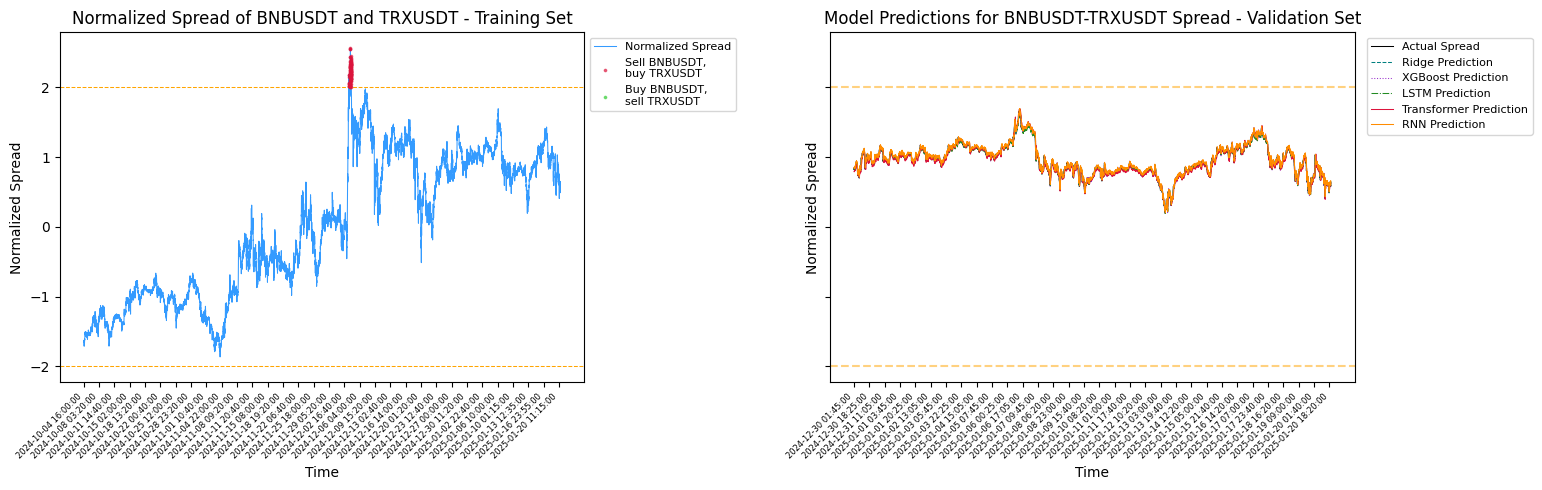

In [4]:
for p in pairs:
    tickerX, tickerY = p.split(' ')
    spread_df = process_pairs_series(tickerX, tickerY, df=df_full)
    spread_df.loc[:, 'Spread'] = spread_df[tickerX] - spread_df[tickerY]
    # Normalize spread
    spread_df.loc[:, 'NormalizedSpread'] = ((spread_df['Spread'] - spread_df['Spread'].mean())
                                            / spread_df['Spread'].std())
    # Generate trading signals based on spreads
    spread_df.loc[:, 'TradingSignal'] = 'No action'  # Changed to .loc
    spread_df.loc[spread_df['NormalizedSpread'] < -2, 'TradingSignal'] = f'Buy {tickerX}, sell {tickerY}'
    spread_df.loc[spread_df['NormalizedSpread'] > 2, 'TradingSignal'] = f'Buy {tickerY}, sell {tickerX}'

    # Preview the data
    display(spread_df.head())

    model_df = spread_df[['NormalizedSpread']].copy()  # Added .copy() to avoid warnings
    # Create 5 lags
    # To be replaced with/extended by Technical Analysis features
    for lag in range(1, 6):
        model_df.loc[:, f'NormalizedSpread_Lag{lag}'] = model_df['NormalizedSpread'].shift(lag)
    model_df = model_df.dropna()

    # Models with default parameters
    ridge, ridge_mse, ridge_test_df = models.ridge_regression(df=model_df)
    xgb, xgb_mse, xgb_test_df = models.xgboost_regression(df=model_df)
    lstm, lstm_mse, lstm_test_df = models.lstm_regression(df=model_df)
    rnn, rnn_mse, rnn_test_df = models.rnn_regression(df=model_df)
    trf, trf_mse, trf_test_df = models.transformer_regression(df=model_df)

    # Plot forecasts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    plot_spread(spread_df, tickerX, tickerY, ax=ax1)
    models.plot_model_forecasts(ridge_test_df, xgb_test_df, lstm_test_df,
                                trf_test_df, rnn_test_df, tickerX, tickerY, ax=ax2)
    plt.show();
    spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')